In [ ]:
# !pip install pyloudnorm torchmetrics

In [1]:
from IPython import display as disp
import torch
import torchaudio
from scipy.signal import wiener, convolve
from scipy.special import sinc
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib
import soundfile
import torchvision
from torchvision import transforms, utils
import librosa
import soundfile as sf
import pyloudnorm as pyln
import torchmetrics
import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0')

In [4]:
!wget https://spandh.dcs.shef.ac.uk/avlombard/data/lombardgrid_audio.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [5]:
!unzip -q lombardgrid_audio.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [6]:
def snr_mixer(clean, noise, snr):
    amp_noise = np.linalg.norm(clean) / 10**(snr / 20)

    noise_norm = (noise / np.linalg.norm(noise)) * amp_noise

    mix = clean + noise_norm

    return mix

def vad_merge(w, top_db):
    intervals = librosa.effects.split(w, top_db=top_db)
    temp = list()
    for s, e in intervals:
        temp.append(w[s:e])
    return np.concatenate(temp, axis=None)

def cut_audios(s1, s2, sec, sr):
    cut_len = sr * sec
    len1 = len(s1)
    len2 = len(s2)

    s1_cut = []
    s2_cut = []

    segment = 0
    while (segment + 1) * cut_len < len1 and (segment + 1) * cut_len < len2:
        s1_cut.append(s1[segment * cut_len:(segment + 1) * cut_len])
        s2_cut.append(s2[segment * cut_len:(segment + 1) * cut_len])

        segment += 1

    return s1_cut, s2_cut

def fix_length_(s, L):
    if s.shape[1] >= L:
        s = s[:, :L]
    else:
        s = torch.cat((s, torch.zeros(L - s.shape[1]).to(s.device)[None, :]), dim=1)
    return s

def fix_length(s1, s2, method='max'):
    if method == 'min':
        utt_len = min(s1.shape[1], s2.shape[1])
    elif method == 'max':
        utt_len = max(s1.shape[1], s2.shape[1])
    else:
        utt_len = method
    s1 = fix_length_(s1, utt_len)
    s2 = fix_length_(s2, utt_len)
    return s1, s2

In [7]:
def snr(est, target):
    return 20 * np.log10(torch.norm(target) / (torch.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / torch.norm(target)**2
    return 20 * torch.log10(torch.norm(alpha * target) / (torch.norm(alpha * target - est) + 1e-6) + 1e-6)

In [8]:
import os
wav1, sr1 = torchaudio.load("../audio/" + os.listdir("../audio")[2221], format="wav")
disp.display(disp.Audio(wav1.numpy(), rate=sr1))

import os
wav2, sr2 = torchaudio.load("../audio/" + os.listdir("../audio")[1000], format="wav")
disp.display(disp.Audio(wav2.numpy(), rate=sr2))

disp.display(disp.Audio(wav2.numpy() + wav1.numpy()[:, :37920], rate=sr2))


In [9]:
print(wav1.shape, wav2.shape)
wav1, wav2 = fix_length(wav1, wav2, method=40000)
print(wav1.shape, wav2.shape)

wav_mixed = snr_mixer(wav1, wav2, snr=10)
disp.display(disp.Audio(wav_mixed, rate=sr2))

torch.Size([1, 44160]) torch.Size([1, 37920])
torch.Size([1, 40000]) torch.Size([1, 40000])


In [10]:
si_sdr(wav_mixed, wav1)

tensor(9.9902)

In [11]:
meter = pyln.Meter(sr1)
loudness = meter.integrated_loudness(wav2.numpy()[0, :])
wav2_normalized = pyln.normalize.loudness(wav2.numpy()[0, :], input_loudness=loudness, target_loudness=-20)
disp.display(disp.Audio(wav2_normalized, rate=sr2))

In [12]:
wav0 = vad_merge(wav1.numpy()[0, :], 5)
disp.display(disp.Audio(wav0, rate=sr2))

In [13]:
from torch.utils.data import Dataset, DataLoader

class GRIDDataset(Dataset):
    """
    GRID dataset

    https://spandh.dcs.shef.ac.uk/avlombard
    """

    def __init__(self, root_dir, format='wav', lufs=-23.0, transform=None):
        """
        Arguments:
            root_dir (string): A path, root directory.
        """
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.format = format
        self.transform = transform
        self.lufs = lufs
        self.meter = None

    def __len__(self):
        return len(self.files) // 15

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        speaker = float(self.files[idx].split("_")[0][1:])
        signal, sr = torchaudio.load(
            self.root_dir + "/" + self.files[idx],
            format=self.format
        )

        if not self.meter:
            self.meter = pyln.Meter(sr)

        signal_numpy = signal.numpy()[0, :]
        louds = self.meter.integrated_loudness(signal_numpy)
        signal = torch.Tensor(pyln.normalize.loudness(signal_numpy, louds, self.lufs)).unsqueeze(0)

        sample = {'speaker' : speaker, 'signal': signal, 'sr' : sr}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [14]:
def collate_grid(batch):
  # L = max([x['signal'].shape[1] for x in batch])
  # L = 40000
  # T = 100
  # batch_ = []
  # for x in batch:
  #   if x['spectrogram'].shape[2] >= T:
  #     batch_.append(x)
  # batch = batch_
  # for x in batch:
  #   if x['signal'].shape[1] < L:
  #     x['signal'] = torch.cat((x['signal'], torch.zeros(1, L - x['signal'].shape[1])), dim=1)
  #   else:
  #     x['signal'] = x['signal'][:, :L]
  #   # x['spectrogram'] = torch.flatten(x['spectrogram'][:, :, :T], start_dim=1)
  #   x['spectrogram'] = x['spectrogram'][:, :, :T]
  return {
      'signal': torch.stack([x['signal'] for x in batch]),
      'spectrogram': torch.stack([x['spectrogram'] for x in batch]),
      'speaker': torch.tensor([x['speaker'] for x in batch]),
      'sr': torch.tensor([x['sr'] for x in batch])
}

In [15]:
def melForward(f):
    return 2595*torch.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

def get_spectrogram(signal):
    nFFT = 1024
    windowSize = nFFT
    hopSize = 256
    window = torch.hann_window(windowSize).to(signal.device)

    spectrum1 = torch.stft(
        signal,
        n_fft=nFFT,
        hop_length=hopSize,
        win_length=windowSize,
        window=window,
        center=False,
        onesided=True,
        return_complex=True,
    )

    spectrogram = melForward(spectrum1.abs().pow(2) + 1e-8)
    return spectrogram

class Spectrogrammify(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        signal = sample['signal']
        spectrogram = get_spectrogram(signal)

        res = {}
        for k, v in sample.items():
            res[k] = v
        
        res['spectrogram'] = spectrogram

        return res
    
class NormalizeSpectrogram(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        spectrogram = sample['spectrogram']

        normalize = transforms.Normalize(0, 1)

        res = {}
        for k, v in sample.items():
            res[k] = v

        return res

In [16]:
import random

class MixedDataset(Dataset):
    def __init__(self, dataset, snr=[0, 10], L=40000, lufs=-23.0, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.snr = snr
        self.L = L
        self.meter = None
        self.lufs = lufs

    def __len__(self):
        return len(self.dataset) * (len(self.dataset) - 1) // 2

    def __getitem__(self, idx):
        N = len(self.dataset)
        i, j = idx // N, idx % N

        sample_i, sample_j = self.dataset[i], self.dataset[j]
        assert sample_i['sr'] == sample_j['sr']

        signal1, signal2 = sample_i['signal'], sample_j['signal']
        
        signal1, signal2 = fix_length(signal1, signal2, self.L)

        # if not self.meter:
        #     self.meter = pyln.Meter(sample_i['sr'])

        # louds1 = meter.integrated_loudness(signal1)
        # louds2 = meter.integrated_loudness(signal2)
        # signal1 = pyln.normalize.loudness(signal1, louds1, self.lufs)
        # signal2 = pyln.normalize.loudness(signal2, louds2, self.lufs)

        snr = random.randint(*self.snr)
        signal = snr_mixer(signal1, signal2, snr=snr)

        sample = {
            'speaker1' : sample_i['speaker'],
            'speaker2' : sample_j['speaker'],
            'signal1' : signal1,
            'signal2' : signal2,
            'signal' : signal,
            'sr' : sample_i['sr'],
        }

        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample

In [17]:
ROOT_DIR = '../audio/'
dataset = GRIDDataset(
  root_dir=ROOT_DIR, 
  # transform=transforms.Compose([Spectrogrammify(), NormalizeSpectrogram()])
)
dataset = MixedDataset(
   dataset,
   # transform=transforms.Compose([Spectrogrammify(), NormalizeSpectrogram()]),
   snr=[5, 8],
   L = 40000
)

B = 2
dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])
dataloader_train = DataLoader(dataset_train, batch_size=B,
                        shuffle=True,) # num_workers=2)
dataloader_val = DataLoader(dataset_val, batch_size=B,
                        shuffle=True,) # num_workers=2,)
dataloader_test = DataLoader(dataset_test, batch_size=B,
                        shuffle=True,) # num_workers=2,)

print(dataset[1])

# if __name__ == '__main__':
for i_batch, sample in enumerate(dataloader_train):
    print(i_batch, sample['signal'].shape, sample['sr'][0])
    disp.display(disp.Audio(sample['signal'][0, 0, :].numpy(), rate=sample['sr'][0].item()))

    # observe 4th batch and stop.
    if i_batch == 3:
      break

{'speaker1': 10.0, 'speaker2': 10.0, 'signal1': tensor([[0.0013, 0.0013, 0.0013,  ..., 0.0000, 0.0000, 0.0000]]), 'signal2': tensor([[0.0015, 0.0018, 0.0019,  ..., 0.0000, 0.0000, 0.0000]]), 'signal': tensor([[0.0020, 0.0021, 0.0021,  ..., 0.0000, 0.0000, 0.0000]]), 'sr': 16000}
0 torch.Size([2, 1, 40000]) tensor(16000)


1 torch.Size([2, 1, 40000]) tensor(16000)


2 torch.Size([2, 1, 40000]) tensor(16000)


3 torch.Size([2, 1, 40000]) tensor(16000)


In [18]:
from src.tasnet.conv_tasnet import *
from src.tasnet.SI_SNR import *
from src.tasnet.utility.sdr import *

In [19]:
import wandb
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

def get_labels(sample, target, device, clip_norm=None):
    return torch.stack([get_spectrogram(sample[target][i, ...].to(device)) for i in range(sample[target].shape[0])]).to(device)

def train_epoch(model, dataloader_train, criterion, optimizer, device, iters=None, clip_norm=None):
    losses = []
    accuracies = []
    for i, sample in enumerate(pbar := tqdm.tqdm(dataloader_train)):
        x_batch = sample['signal'].to(device)
        y_batch = torch.stack((sample['signal1'], sample['signal2']), dim=1).squeeze(2).to(device)

        output = model(x_batch) 

        acc = torchmetrics.audio.SignalNoiseRatio().to(device)(output, y_batch)

        sdr = batch_SDR_torch(output, y_batch).mean()
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        if clip_norm:
                clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        losses.append(loss)
        accuracies.append(acc)

        if i % 200 == 0:
            pbar.set_postfix_str(f"MSE: {round(loss.item(), ndigits=2)}, SNR: {round(acc.item(), ndigits=2)}, SDR: {round(sdr.item(), ndigits=2)}")
            columns = ["title", "signal"]
            sr = sample['sr'][0].item()
            data = [
                ["src1", wandb.Audio(sample['signal1'][0, 0, :], sr)], 
                ["src2", wandb.Audio(sample['signal2'][0, 0, :], sr)],
                ["mixed", wandb.Audio(sample['signal'][0, 0, :], sr)],
                ["sep1", wandb.Audio(output[0, 0, :].cpu().detach(), sr)],
                ["sep2", wandb.Audio(output[0, 1, :].cpu().detach(), sr)],
            ]
            wandb.log({"separation" : wandb.Table(columns=columns, data=data)})

        if iters and iters == i:
            break

    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()

def train(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, n_epochs, device, clip_norm, iters):
    wandb.init()
    model.train()
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        loss, acc = train_epoch(model, dataloader_train, criterion, optimizer, device, iters=iters, clip_norm=clip_norm)
        print(f"Train loss: {loss}, acc: {acc}")
        wandb.log({"train_loss" : loss, "train_acc" : acc})

        val_loss, val_acc = test(model, dataloader_val, criterion, device, iters=iters)
        print(f"Val loss: {val_loss}, acc: {val_acc}")
        wandb.log({"val_loss" : val_loss, "val_acc" : val_acc})

        scheduler.step(val_loss)
        wandb.log({"learning rate" : scheduler.get_last_lr()[0]})
        
    wandb.finish()

def save_checkpoint(epoch, model, optimizer, checkpoint, best=True):
    '''
        save model
        best: the best model
    '''
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optim_state_dict": optimizer.state_dict()
        },
        os.path.join(checkpoint,
                        "{0}.pt".format("best" if best else "last")))

def test(model, dataloader_test, criterion, device, iters=None):
    model.eval()
    losses = []
    accuracies = []
    for i, sample in enumerate(pbar := tqdm.tqdm(dataloader_test)):
        x_batch = sample['signal'].to(device)
        y_batch = torch.stack((sample['signal1'], sample['signal2']), dim=1).squeeze(2).to(device)

        with torch.no_grad():
            output = model(x_batch)

            acc = torchmetrics.audio.SignalNoiseRatio().to(device)(output, y_batch)

            loss = criterion(output, y_batch)

            losses.append(loss)
            accuracies.append(acc)

        if i % 100 == 0:
            pbar.set_postfix_str(f"MSE: {round(loss.item(), ndigits=2)}, SNR: {round(acc.item(), ndigits=2)}")
        
        if iters and iters == i:
            break

    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()

In [21]:
min_lr = 1e-7
patience = 2

model = TasNet(enc_dim=128, feature_dim=64, sr=dataset[1]['sr'], win=2, layer=8, stack=3, 
                 kernel=3, num_spk=2, causal=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=patience, verbose=True, min_lr=min_lr)
criterion = nn.MSELoss(reduction='sum')

resume = { 'path' : '', 'resume_state' : True }
if resume['resume_state']:
    path = os.path.join(resume['path'], 'saved', 'best.pt')
    cpt = torch.load(path, map_location='cpu')
    epoch = cpt['epoch']
    print("Resume from checkpoint {}: epoch {:d}".format(path, epoch))
    model.load_state_dict(cpt['model_state_dict'])
    model = model.to(device)
    optimizer.load_state_dict(cpt['optim_state_dict'])

c:\Users\maxro\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Resume from checkpoint saved\best.pt: epoch 1


In [163]:
train(
    model, 
    dataloader_train, 
    dataloader_val, 
    criterion, 
    optimizer, 
    scheduler, 
    n_epochs=20, 
    device=device,
    clip_norm=200,
    iters=2000
)

train_acc,▁
train_loss,▁
train_acc,4.10452
train_loss,18.10756


Epoch 0 of 20


  9%|▉         | 2000/22492 [03:25<35:03,  9.74it/s, MSE: 3.94, SNR: 7.02]   


Train loss: 12.985454559326172, acc: 5.820044994354248


 31%|███       | 2000/6426 [01:46<03:54, 18.86it/s, MSE: 8.93, SNR: 5.66] 


Val loss: 10.082113265991211, acc: 6.893901824951172
Epoch 1 of 20


  9%|▉         | 2000/22492 [03:24<34:57,  9.77it/s, MSE: 12.68, SNR: 8.38] 


Train loss: 8.417736053466797, acc: 7.643718242645264


 31%|███       | 2000/6426 [01:41<03:45, 19.64it/s, MSE: 1.67, SNR: 6.46]  


Val loss: 6.9513702392578125, acc: 8.434126853942871
Epoch 2 of 20


  9%|▉         | 2000/22492 [03:22<34:39,  9.86it/s, MSE: 5.0, SNR: 9.89]   


Train loss: 6.641468524932861, acc: 8.674254417419434


 31%|███       | 2000/6426 [01:39<03:40, 20.10it/s, MSE: 4.11, SNR: 10.44]


Val loss: 6.48969841003418, acc: 8.827392578125
Epoch 3 of 20


  9%|▉         | 2000/22492 [03:13<33:00, 10.35it/s, MSE: 3.35, SNR: 10.6]  


Train loss: 5.740673065185547, acc: 9.328160285949707


 31%|███       | 2000/6426 [01:42<03:47, 19.42it/s, MSE: 2.38, SNR: 12.65]


Val loss: 5.346279144287109, acc: 9.731659889221191
Epoch 4 of 20


  9%|▉         | 2000/22492 [03:04<31:28, 10.85it/s, MSE: 6.74, SNR: 9.68] 


Train loss: 5.178309440612793, acc: 9.766596794128418


 31%|███       | 2000/6426 [01:39<03:39, 20.19it/s, MSE: 4.08, SNR: 8.3]  


Val loss: 5.8271803855896, acc: 9.484501838684082
Epoch 5 of 20


  9%|▉         | 2000/22492 [03:14<33:11, 10.29it/s, MSE: 2.27, SNR: 7.4]  


Train loss: 4.5817718505859375, acc: 10.180619239807129


 31%|███       | 2000/6426 [01:43<03:49, 19.25it/s, MSE: 5.65, SNR: 10.32]


Val loss: 5.208620071411133, acc: 9.902843475341797
Epoch 6 of 20


  9%|▉         | 2000/22492 [03:06<31:48, 10.74it/s, MSE: 2.65, SNR: 11.41]  


Train loss: 4.652954578399658, acc: 10.35640811920166


 31%|███       | 2000/6426 [01:21<02:59, 24.62it/s, MSE: 4.75, SNR: 10.72]


Val loss: 4.14412784576416, acc: 10.629472732543945
Epoch 7 of 20


  9%|▉         | 2000/22492 [02:25<24:48, 13.77it/s, MSE: 2.5, SNR: 9.39]  


Train loss: 4.1821513175964355, acc: 10.675158500671387


 31%|███       | 2000/6426 [01:16<02:49, 26.16it/s, MSE: 2.47, SNR: 10.37]


Val loss: 4.402625560760498, acc: 10.413372039794922
Epoch 8 of 20


  9%|▉         | 2000/22492 [02:38<27:05, 12.61it/s, MSE: 1.5, SNR: 12.21]


Train loss: 4.189602851867676, acc: 10.7823486328125


 31%|███       | 2000/6426 [01:18<02:54, 25.42it/s, MSE: 2.39, SNR: 10.78]


Val loss: 3.7069857120513916, acc: 11.167715072631836
Epoch 9 of 20


  9%|▉         | 2000/22492 [02:53<29:40, 11.51it/s, MSE: 7.01, SNR: 11.43]  


Train loss: 3.959261178970337, acc: 10.929732322692871


 31%|███       | 2000/6426 [01:41<03:45, 19.63it/s, MSE: 5.01, SNR: 10.32]


Val loss: 3.9120945930480957, acc: 11.044782638549805
Epoch 10 of 20


  9%|▉         | 2000/22492 [03:03<31:17, 10.92it/s, MSE: 14.54, SNR: 10.85]


Train loss: 3.6626007556915283, acc: 11.221945762634277


 31%|███       | 2000/6426 [01:37<03:34, 20.62it/s, MSE: 6.21, SNR: 11.25]


Val loss: 3.992405414581299, acc: 10.615897178649902
Epoch 11 of 20


  9%|▉         | 2000/22492 [03:16<33:30, 10.19it/s, MSE: 1.19, SNR: 13.2]  


Train loss: 3.5147082805633545, acc: 11.437445640563965


 31%|███       | 2000/6426 [01:46<03:55, 18.82it/s, MSE: 9.6, SNR: 8.27]  


Val loss: 3.907137632369995, acc: 10.852925300598145
Epoch 12 of 20


  9%|▉         | 2000/22492 [03:05<31:38, 10.80it/s, MSE: 1.48, SNR: 11.91] 


Train loss: 3.0518364906311035, acc: 12.109929084777832


 31%|███       | 2000/6426 [01:43<03:48, 19.38it/s, MSE: 2.58, SNR: 12.37]


Val loss: 3.045297145843506, acc: 12.107495307922363
Epoch 13 of 20


  9%|▉         | 2000/22492 [03:14<33:07, 10.31it/s, MSE: 0.93, SNR: 12.36] 


Train loss: 2.881362199783325, acc: 12.180639266967773


 31%|███       | 2000/6426 [01:44<03:51, 19.09it/s, MSE: 2.05, SNR: 11.4]  


Val loss: 2.8847122192382812, acc: 12.255595207214355
Epoch 14 of 20


  9%|▉         | 2000/22492 [03:23<34:48,  9.81it/s, MSE: 0.55, SNR: 11.2]   


Train loss: 2.710998058319092, acc: 12.401347160339355


 31%|███       | 2000/6426 [01:42<03:47, 19.47it/s, MSE: 0.86, SNR: 12.98]


Val loss: 2.7451107501983643, acc: 12.468384742736816
Epoch 15 of 20


  9%|▉         | 2000/22492 [02:49<28:58, 11.79it/s, MSE: 0.5, SNR: 13.05]   


Train loss: 2.597346782684326, acc: 12.461761474609375


 31%|███       | 2000/6426 [01:46<03:54, 18.86it/s, MSE: 0.62, SNR: 11.5] 


Val loss: 2.5836079120635986, acc: 12.655755043029785
Epoch 16 of 20


  9%|▉         | 2000/22492 [03:19<34:02, 10.03it/s, MSE: 1.95, SNR: 12.83]


Train loss: 2.6112589836120605, acc: 12.530413627624512


 31%|███       | 2000/6426 [01:37<03:36, 20.49it/s, MSE: 1.98, SNR: 12.82]


Val loss: 2.5625104904174805, acc: 12.714452743530273
Epoch 17 of 20


  9%|▉         | 2000/22492 [03:07<32:02, 10.66it/s, MSE: 5.0, SNR: 10.2]   


Train loss: 2.650463819503784, acc: 12.61359977722168


 31%|███       | 2000/6426 [01:35<03:31, 20.94it/s, MSE: 1.0, SNR: 12.1]  


Val loss: 2.4267022609710693, acc: 12.811933517456055
Epoch 18 of 20


  9%|▉         | 2000/22492 [03:07<32:02, 10.66it/s, MSE: 2.5, SNR: 13.58]  


Train loss: 2.550252676010132, acc: 12.787009239196777


 31%|███       | 2000/6426 [01:32<03:24, 21.69it/s, MSE: 3.62, SNR: 13.72]


Val loss: 2.4700124263763428, acc: 12.954154968261719
Epoch 19 of 20


  9%|▉         | 2000/22492 [03:13<33:00, 10.34it/s, MSE: 5.89, SNR: 12.76]  


Train loss: 2.48582124710083, acc: 12.835336685180664


 31%|███       | 2000/6426 [01:39<03:39, 20.19it/s, MSE: 1.5, SNR: 12.02] 


Val loss: 2.4601621627807617, acc: 12.893403053283691


learning rate,███████████▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▅▅▅▆▆▆▆▆▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▃▄▄▄▅▅▆▆▅▆▇▇▇█████
val_loss,█▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
learning rate,0.0005
train_acc,12.83534
train_loss,2.48582
val_acc,12.8934
val_loss,2.46016


In [22]:
test(model, dataloader_test, criterion, device)

100%|██████████| 3213/3213 [02:23<00:00, 22.45it/s, MSE: 77.56, SNR: 12.39] 


(379.7238464355469, 10.209632873535156)

In [169]:
save_checkpoint(1, model, optimizer, "saved")

In [23]:
sample = next(iter(dataloader_train))
sample

{'speaker1': tensor([10., 11.], dtype=torch.float64),
 'speaker2': tensor([10., 11.], dtype=torch.float64),
 'signal1': tensor([[[-0.0046, -0.0050, -0.0051,  ..., -0.0014, -0.0002,  0.0028]],
 
         [[-0.0072, -0.0055, -0.0047,  ...,  0.0000,  0.0000,  0.0000]]]),
 'signal2': tensor([[[ 0.0011,  0.0013,  0.0011,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0047, -0.0050, -0.0050,  ...,  0.0000,  0.0000,  0.0000]]]),
 'signal': tensor([[[-0.0041, -0.0044, -0.0046,  ..., -0.0014, -0.0002,  0.0028]],
 
         [[-0.0091, -0.0075, -0.0067,  ...,  0.0000,  0.0000,  0.0000]]]),
 'sr': tensor([16000, 16000])}

In [24]:
output = model(sample['signal'].to(device))
output.shape

torch.Size([2, 2, 40000])

In [25]:
idx = 0
disp.display(disp.Audio(sample['signal1'][idx, 0, :].numpy(), rate=int(sample['sr'][idx])))
disp.display(disp.Audio(sample['signal2'][idx, 0, :].numpy(), rate=int(sample['sr'][idx])))
disp.display(disp.Audio(sample['signal'][idx, 0, :].numpy(), rate=int(sample['sr'][idx])))
disp.display(disp.Audio(output[idx, 0, :].cpu().detach().numpy(), rate=int(sample['sr'][idx])))

In [162]:
import gc
torch.cuda.empty_cache()
gc.collect()

6093

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [138]:
import os
wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[100], format="wav")
disp.display(disp.Audio(wav.numpy(), rate=sr))

In [139]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(windowSize)

In [140]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

torch.Size([1, 513, 50])


C:\Users\maxro\AppData\Local\Temp\ipykernel_5112\3846563539.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


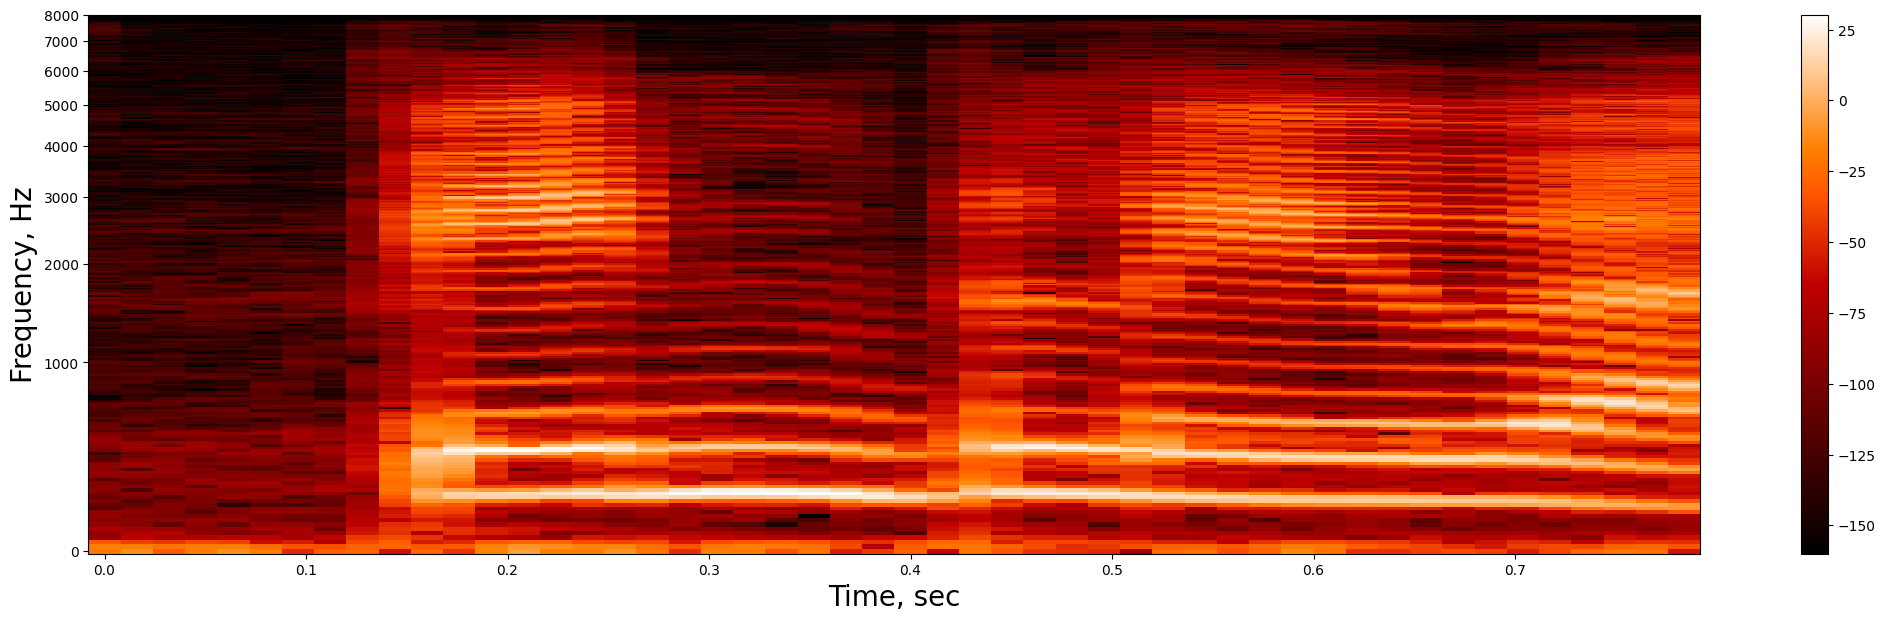

In [230]:
spectrum1 = torch.stft(
    wav,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window,
    center=False,
    onesided=True,
    return_complex=True,
)

# spectrogram = spectrum1.norm(dim=-1).pow(2)

# spectrum1[:, :67] = 0
# spectrum1[:, :100] = 0

spectrogram = spectrum1.abs().pow(2)

spectrogram = spectrogram[:, :, :50]
print(spectrogram.shape)

f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(0,nFFT/2+0.00001)/(nFFT)*sr
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spectrogram.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [220]:
spectrogram.shape

torch.Size([1, 513, 100])

In [113]:
torch.flatten(spectrogram, start_dim=1).shape

torch.Size([1, 68742])

In [452]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(windowSize).to(device)

In [38]:
wav_revived = torch.istft(torch.Tensor(output, dtype=torch.complex64),
                          n_fft=nFFT,
                          hop_length=hopSize,
                          win_length=windowSize,
                          window=window)
wav_revived.shape

TypeError: new() received an invalid combination of arguments - got (Tensor, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [ ]:
disp.display(disp.Audio(wav_revived.numpy(), rate=sr))

In [ ]:
torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1).shape

torch.Size([1, 44320])

In [ ]:
torch.norm(torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1)) / wav.shape[1]

tensor(6.7353e-05)